<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1599 non-null   float64
 1   volatile acidity      1599 non-null   float64
 2   citric acid           1599 non-null   float64
 3   residual sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free sulfur dioxide   1599 non-null   float64
 6   total sulfur dioxide  1599 non-null   float64
 7   density               1599 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   float64
 11  quality               1599 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 150.0 KB
Red wine shape: (1599, 12)


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.40,0.70,0.00,1.90,0.08,11.00,34.00,1.00,3.51,0.56,9.40,5
1,7.80,0.88,0.00,2.60,0.10,25.00,67.00,1.00,3.20,0.68,9.80,5
2,7.80,0.76,0.04,2.30,0.09,15.00,54.00,1.00,3.26,0.65,9.80,5
3,11.20,0.28,0.56,1.90,0.07,17.00,60.00,1.00,3.16,0.58,9.80,6
4,7.40,0.70,0.00,1.90,0.08,11.00,34.00,1.00,3.51,0.56,9.40,5


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
1594,6.20,0.60,0.08,2.00,0.09,32.00,44.00,0.99,3.45,0.58,10.50,5
1595,5.90,0.55,0.10,2.20,0.06,39.00,51.00,1.00,3.52,0.76,11.20,6
1596,6.30,0.51,0.13,2.30,0.08,29.00,40.00,1.00,3.42,0.75,11.00,6
1597,5.90,0.65,0.12,2.00,0.07,32.00,44.00,1.00,3.57,0.71,10.20,5
1598,6.00,0.31,0.47,3.60,0.07,18.00,42.00,1.00,3.39,0.66,11.00,6


,Numero di vini
Qualità,
3,10
4,53
5,681
6,638
7,199
8,18


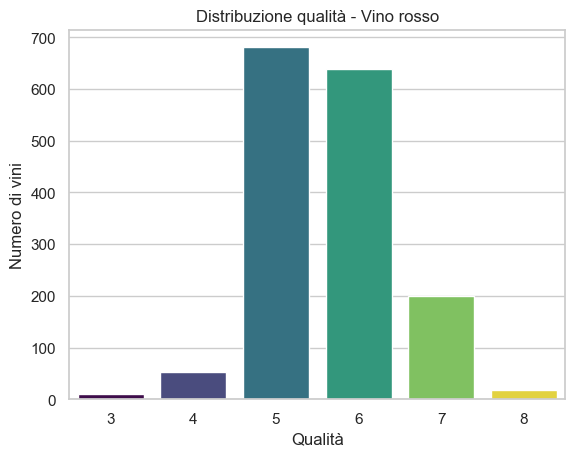

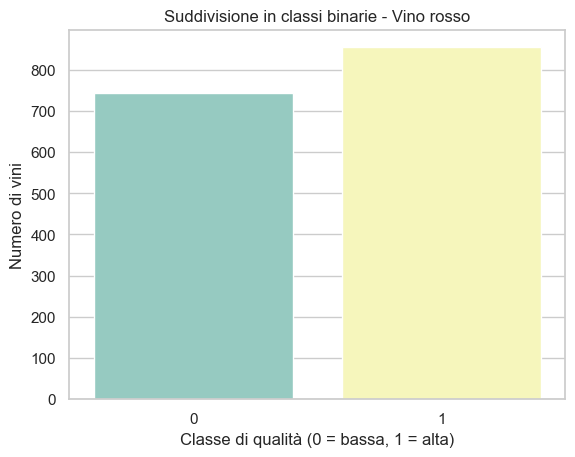

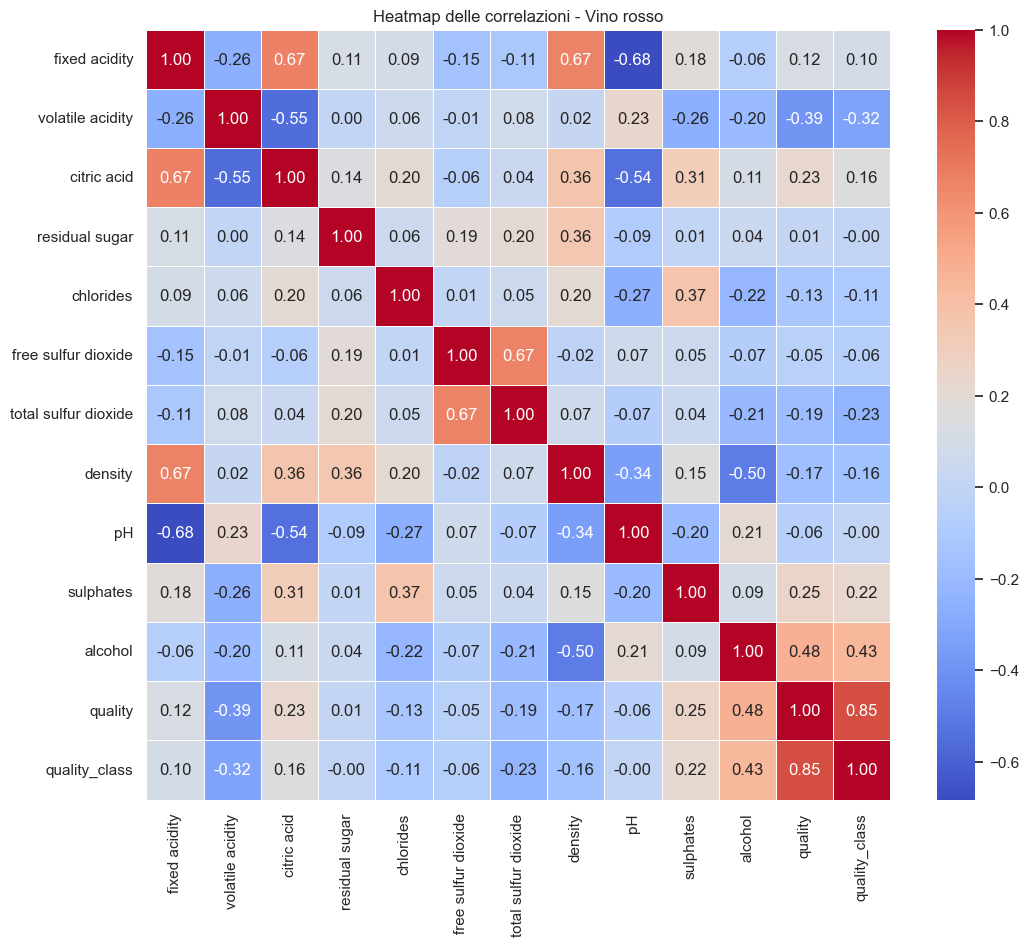

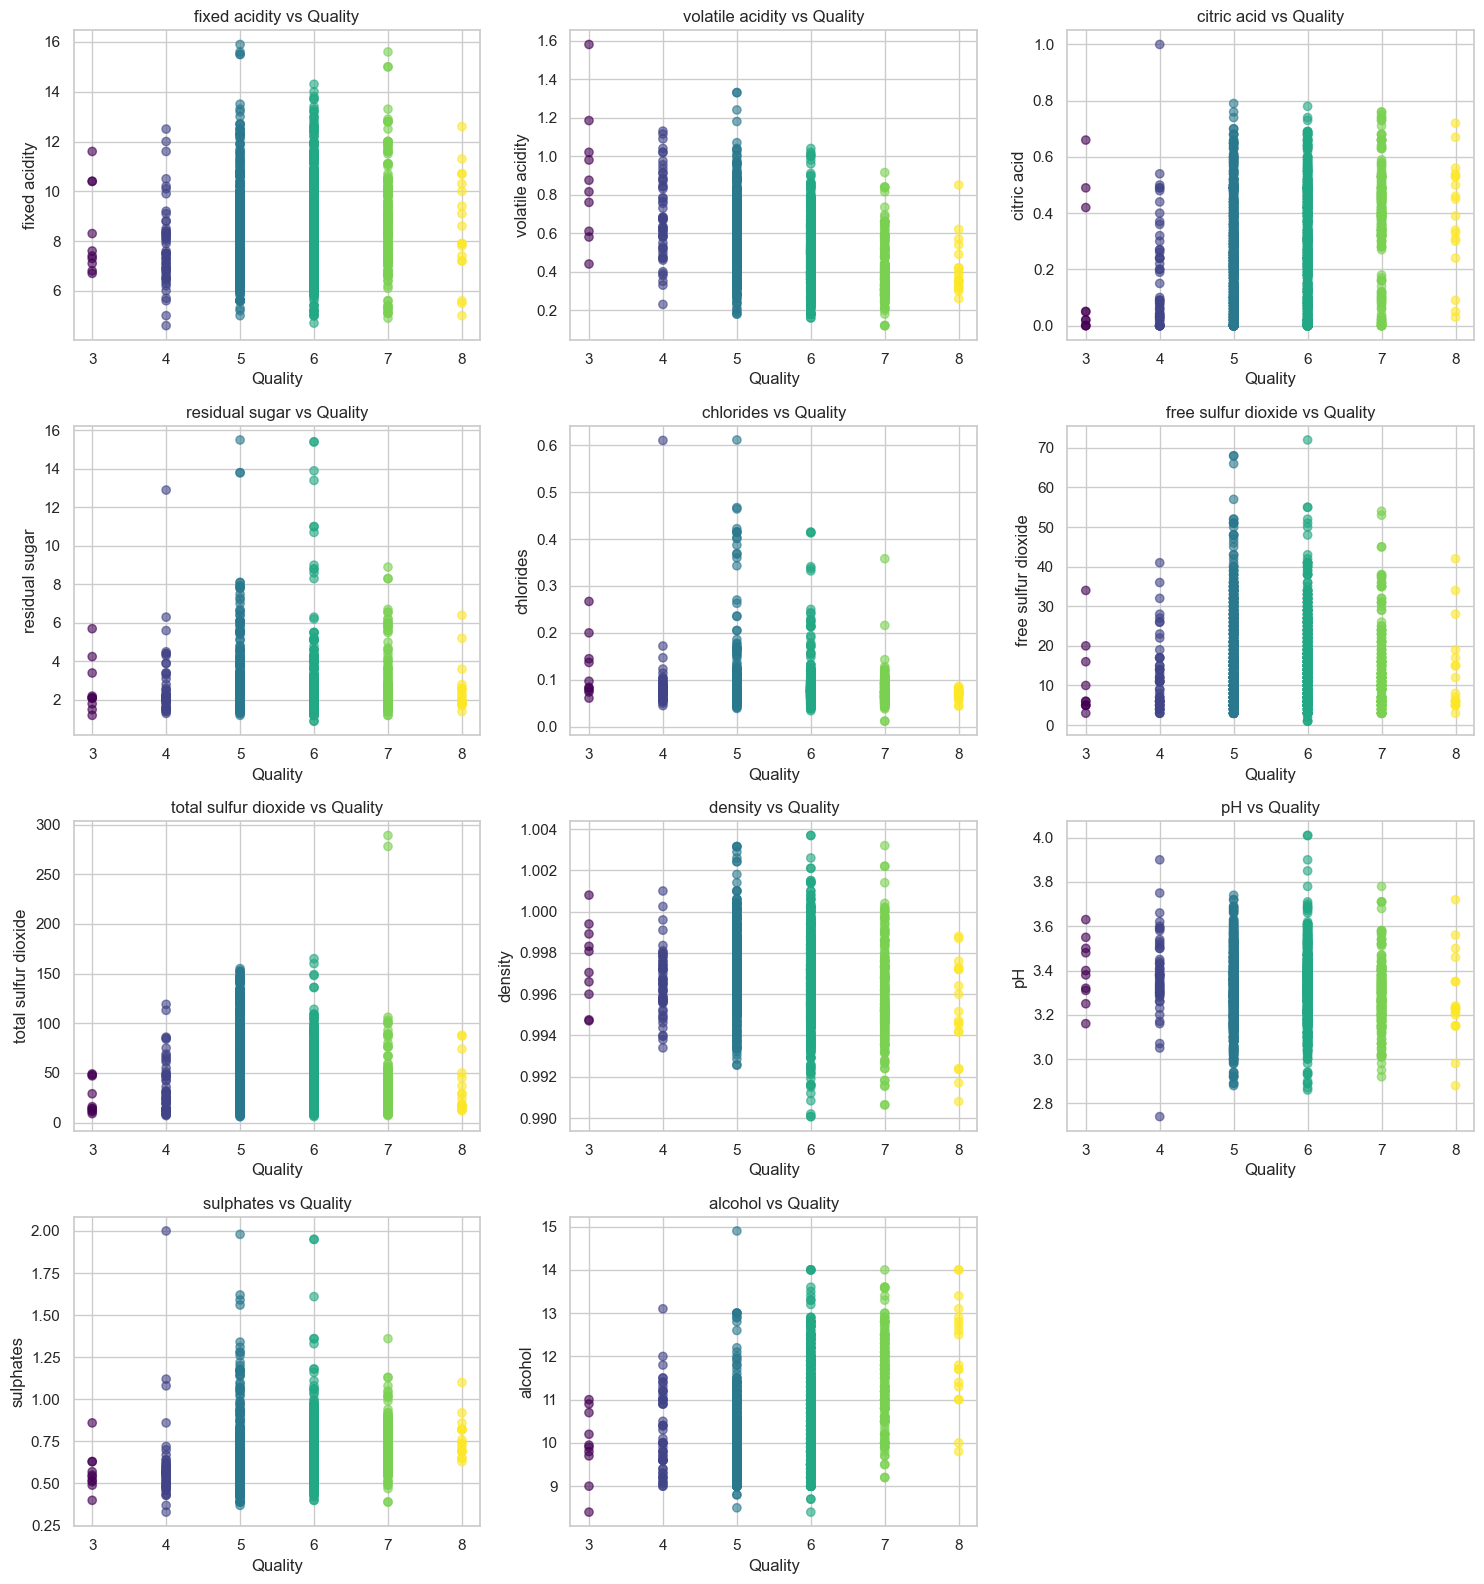

In [2]:
# Librerie
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display


# Imposto uno stile per i grafici
sns.set(style="whitegrid")

# Leggo i dati (PERFETTO per la tua struttura)
df_red = pd.read_csv('../data/winequality-red.csv', sep=';')
df_white = pd.read_csv('../data/winequality-white.csv', sep=';')

df_red.info()

# Info sui dati
print("Red wine shape:", df_red.shape)
#print("White wine shape:", df_white.shape)

# Opzione per vedere tutte le colonne (evita i "...")
pd.set_option('display.max_columns', None)

# Funzione per visualizzare una parte del DataFrame
def mostra(df, righe=5, titolo="Anteprima del DataFrame"):
    styled = (
        df.head(righe)
          .style.set_caption(titolo)
          .background_gradient(cmap='Blues')
          .set_table_styles([
              {'selector': 'th', 'props': [('font-size', '12pt'), ('text-align', 'center')]},
              {'selector': 'td', 'props': [('font-size', '11pt')]}
          ])
    )
    display(styled)

# Prime righe
df_red.head()

# Versione per gli ultimi dati
def mostra_righe(df, righe=5, titolo="Ultime righe del DataFrame"):
    styled = (
        df.tail(righe)
          .style.set_caption(titolo)
          .format(precision=2)
          .background_gradient(cmap='Oranges')
    )
    display(styled)

mostra_righe(df_red.head(), 5, "Prime 5 righe del dataset - Vino Rosso")
#mostra(df_white, 5, "Prime 10 righe del dataset - Vino Bianco")

mostra_righe(df_red.tail(), 5, "Ultime 5 righe - Vino Rosso")

#Conteggio qualità
df_quality = df_red['quality'].value_counts().sort_index().to_frame(name='Numero di vini')
df_quality.index.name = 'Qualità'
mostra(df_quality, righe=len(df_quality), titolo="Distribuzione dei vini per qualità")


# Statistiche descrittive
df_red.describe()

# Check null
df_red.isnull().sum()

# 1 - Distribuzione qualità (conteggio)
sns.countplot(x='quality', data=df_red, hue='quality', palette='viridis', legend=False)
plt.title("Distribuzione qualità - Vino rosso")
plt.xlabel("Qualità")
plt.ylabel("Numero di vini")
plt.show()

def qualità_in_classi(q):
    if q <= 5:
        return 0
    else:
        return 1

df_red['quality_class'] = df_red['quality'].apply(qualità_in_classi)

# 2 – Distribuzione classi binarie
sns.countplot(x='quality_class', data=df_red, hue='quality_class', palette='Set3', legend=False)
plt.title("Suddivisione in classi binarie - Vino rosso")
plt.xlabel("Classe di qualità (0 = bassa, 1 = alta)")
plt.ylabel("Numero di vini")
plt.show()

# Correlazioni tra variabili
plt.figure(figsize=(12,10))
sns.heatmap(df_red.corr(), annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title("Heatmap delle correlazioni - Vino rosso")
plt.show()


# Prendiamo solo le colonne numeriche, escludendo 'quality' come target
features = df_red.select_dtypes(include='number').columns.drop(['quality_class','quality'])

# Creiamo i sottoplot
n = len(features)
cols = 3
rows = (n // cols) + (n % cols > 0)

plt.figure(figsize=(cols * 5, rows * 4))

for i, col in enumerate(features, 1):
    plt.subplot(rows, cols, i)
    plt.scatter(df_red['quality'], df_red[col], c=df_red['quality'], cmap='viridis', alpha=0.6)
    plt.title(f"{col} vs Quality")
    plt.xlabel("Quality")
    plt.ylabel(col)

plt.tight_layout()
plt.show()


In [ ]:
# Selezione delle feature numeriche, esclusa 'quality_class' e 'quality'
features = df_red.select_dtypes(include='number').drop(columns=['quality', 'quality_class'])

# Scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(features)

# PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Creazione DataFrame con PCA e qualità
df_pca = pd.DataFrame(data=X_pca, columns=['PC1', 'PC2'])
df_pca['quality'] = df_red['quality'].values

# Plot
plt.figure(figsize=(10, 8))
sns.scatterplot(data=df_pca, x='PC1', y='PC2', hue='quality', palette='viridis', alpha=0.7, s=80)
plt.title("PCA - Vino rosso (colorato per qualità)")
plt.xlabel("Componente Principale 1")
plt.ylabel("Componente Principale 2")
plt.legend(title='Qualità', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()
